# Image classification with Vision Transformer

In [31]:
#  -------------------------------------------------------------------------------------------------
#   Copyright (c) 2024.  SupportVectors AI Lab
#   This code is part of the training material, and therefore part of the intellectual property.
#   It may not be reused or shared without the explicit, written permission of SupportVectors.
#
#   Use is limited to the duration and purpose of the training at SupportVectors.
#
#   Author: SupportVectors AI Training Team
#  -------------------------------------------------------------------------------------------------

In the previous lab, we saw how we can finetune a CNN model for Image classification. In this notebook we will take a look at the results of a full finetuning performed on a Vision Transformer.

**Vision Transformers (ViTs)** are a breakthrough architecture in computer vision, leveraging the transformer model—originally designed for NLP tasks—to process and classify images. Unlike convolutional neural networks (CNNs), which rely on convolutions to capture spatial hierarchies, ViTs treat an image as a sequence of patches, much like words in a sentence. Each image is split into small patches, which are linearly embedded and combined with positional encodings to retain spatial information. These embeddings are then fed into a series of transformer layers that model long-range dependencies across patches.

One of the core advantages of ViTs is their ability to capture global relationships without the inductive biases inherent in convolutions. While CNNs prioritize local features early on, ViTs learn patterns and dependencies over the entire image right from the start, making them particularly effective on large datasets where global context is crucial. However, this flexibility comes at a computational cost, as ViTs generally require significant data and training time to outperform traditional CNNs.

In this notebook, we’ll explore how to fine-tune a Vision Transformer for image classification, adapting its weights to our specific dataset. This approach will allow us to leverage the model’s pre-trained capabilities while honing it for our unique task, leading to faster convergence and potentially higher performance

## Setup



In [32]:

from PIL import Image
import json
import joblib

# torch
import torch

# svlearn
from svlearn.config.configuration import ConfigurationMixin
from svlearn.common.utils import ensure_directory
# huggingface
from transformers import ViTImageProcessor, ViTForImageClassification

# sklearn
from sklearn.preprocessing import LabelEncoder

## The model - vit-base-patch16-224-in21k
The **google/vit-base-patch16-224-in21k** is a Vision Transformer model fine-tuned on the large **ImageNet-21k** dataset, consisting of 21,000 classes. This specific model follows the "base" variant of the Vision Transformer, meaning it has 12 transformer layers (blocks), each with 12 self-attention heads, and a hidden dimension of 768.

Key features of this model include:

- **Patch Size 16x16**: Each 224x224 input image is divided into 16x16 patches, resulting in a sequence of 196 patches (plus one additional "classification token") that the model processes.
- **Positional Embeddings**: Since transformers lack an inherent understanding of spatial order, positional encodings are added to each patch embedding, allowing the model to learn the spatial structure of images.
- **ImageNet-21k Pretraining**: Trained on a vast dataset (14 million images across 21k classes), this model has seen a diverse range of objects, making it a strong base for transfer learning tasks in various domains.


In [33]:
# configurations

config = ConfigurationMixin().load_config()

data_dir = config['tree-classification']['data']
raw_dir = data_dir + '/raw'
processed_dir = data_dir + "/preprocessed"
ensure_directory(processed_dir)

results_dir = config['tree-classification']['results'] + "/" + 'vit'
ensure_directory(results_dir)

model_name_or_path = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name_or_path)

/home/devops/kayal/ai-intro/docs/notebooks/vision_transformers


## Model Performance with Transfer learning

We have finetuned the model [here](src/svlearn/encoder_models/vit_full_ft_trainer.py). Let's see it's performance with simply training the classification head.

In [35]:
model_dir = results_dir
model: ViTForImageClassification = ViTForImageClassification.from_pretrained(model_dir, output_attentions=True, attn_implementation="eager")
model.eval()

label_encoder: LabelEncoder = joblib.load(f"{results_dir}/label_encoder.joblib")
labels = label_encoder.classes_
labels

array(['Oak', 'WeepingWillow'], dtype=object)

In [23]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [24]:
model.config

ViTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "/home/devops/kayal/results/trees/vit",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Oak",
    "1": "WeepingWillow"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Oak": "0",
    "WeepingWillow": "1"
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "output_attentions": true,
  "patch_size": 16,
  "problem_type": "single_label_classification",
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.46.2"
}

We load an image that the model has not yet seen. You can download the image from [here](https://www.nashvilletreeconservationcorps.org/treenews/how-many-oak-tree-varieties)

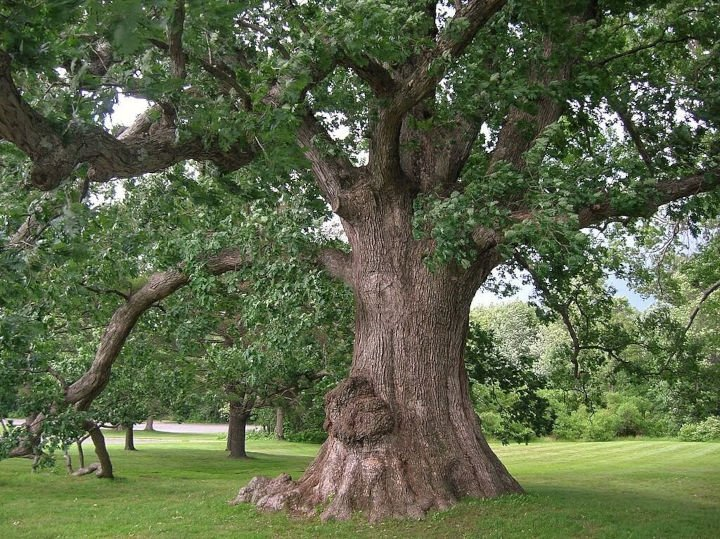

In [25]:
validation_sample = Image.open(f"{data_dir}/test_oak_tree.jpg")
validation_sample

In [26]:
input = processor(validation_sample, return_tensors="pt")
label_encoder.inverse_transform(model(**input).logits.argmax(axis=1))

array(['Oak'], dtype=object)

In [27]:
input['pixel_values'].shape

torch.Size([1, 3, 224, 224])

## Patch embedding

In [29]:
class PatchEmbeddingExtractor(torch.nn.Module):
    def __init__(self, model: ViTForImageClassification):
        super().__init__()
        # Save the original model
        self.vit_model = model
    
    def forward(self, x):
        # Get the patch embeddings layer
        patch_embeddings = self.vit_model.vit.embeddings.patch_embeddings
        # Run input through the patch embedding layer's projection (Conv2d)
        patch_embeds = patch_embeddings.projection(x)
        return patch_embeds

embedding_extractor = PatchEmbeddingExtractor(model)


# Get patch embeddings
patch_embeddings = embedding_extractor(input['pixel_values'])
print("Patch Embeddings Shape:", patch_embeddings.shape)

Patch Embeddings Shape: torch.Size([1, 768, 14, 14])


## Positional embedding

In [30]:
# Access ViT Embeddings layer
embeddings = model.vit.embeddings

# Print properties of the ViT Embeddings
print("ViT Embeddings Properties:")

# Access and print patch embeddings layer
print("Patch Embeddings Conv2d Layer:")
print(embeddings.patch_embeddings.projection)  # Conv2d layer for patch embeddings

# Access positional embeddings
print("Positional Embeddings Shape:", embeddings.position_embeddings.shape)

ViT Embeddings Properties:
Patch Embeddings Conv2d Layer:
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
Positional Embeddings Shape: torch.Size([1, 197, 768])


Let's evaluate it's performance on the validation dataset and compute the evaluation metrics to get the entire picture.

In [11]:
with open(f"{model_dir}/eval_results.json") as f:
    eval_results_tl = json.load(f)

eval_results_tl

{'epoch': 4.0,
 'eval_accuracy': 0.9912280701754386,
 'eval_f1': 0.9859154929577465,
 'eval_loss': 0.030940623953938484,
 'eval_precision': 1.0,
 'eval_recall': 0.9722222222222222,
 'eval_runtime': 1.395,
 'eval_samples_per_second': 81.722,
 'eval_steps_per_second': 10.753}

Looks like our model performs extremely well with simply training the classification layers

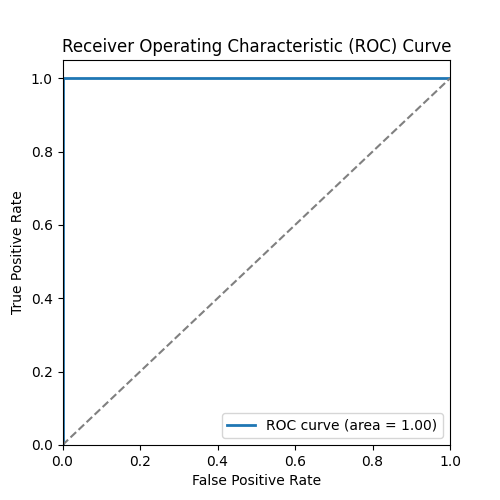

In [12]:
Image.open(f"{model_dir}/roc.png")

let's also take a look at how long transfer learning took to train

In [13]:
with open(f"{model_dir}/train_results.json") as f:
    train_results_tl= json.load(f)

train_results_tl

{'epoch': 4.0,
 'total_flos': 3.525885527463936e+18,
 'train_loss': 0.08374601409740422,
 'train_runtime': 504.5567,
 'train_samples_per_second': 90.178,
 'train_steps_per_second': 5.637}

## Conclusion

Our results demonstrate that transfer learning alone achieved a perfect accuracy of 1.0, indicating that the pre-trained features from the Vision Transformer effectively captured the patterns needed for accurate classification on our dataset. In contrast, full fine-tuning yielded a slightly lower accuracy of 0.9846, suggesting that adjusting all model parameters might have led to minor overfitting or disruption of the pre-trained features. This outcome highlights the strength of transfer learning with Vision Transformers, where selectively fine-tuning only the final layers can preserve the powerful generalizations learned during pretraining, delivering high performance with less computational cost and faster convergence.